In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import product
import statsmodels.api as sm
from PortfolioAnalysis import *

from DataPipeline import DataPipeline, MSE, R2, r2_metrics

file_path = '/Users/zequnli/LocalData/'

2024-05-22 17:59:16.921187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data
dataset = DataPipeline(file_path)
train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
train_N = train_mask.sum()
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
validation_N = validation_mask.sum()
test_mask = (dataset.data['yyyymm'] > 198900)
test_N = test_mask.sum()
N = dataset.data.shape[0]

# ML OOS Prediction

In [4]:
# initiate a result dataframe
# yyyymm and permno for merging purpose
# me and exret for calculating portfolio return
OOSresults = dataset.data[['yyyymm','permno','me','exret']][test_mask].copy()

### NN3

In [5]:
from tensorflow.keras.models import load_model

y_test = []
y_pred = []
for year in range(1989,2022):
    model = load_model(file_path+'NN3_model/NN3_'+str(year)+'.keras', custom_objects={'r2_metrics': r2_metrics})
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

2024-05-20 21:40:43.917726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2440/2440 [==============================] - 2s 649us/step


In [6]:
OOSresults = OOSresults.assign(pred_nn3 = np.array(y_pred).reshape(-1))

### RF

In [7]:
from joblib import load
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF_model/RF_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [8]:
OOSresults = OOSresults.assign(pred_rf = np.array(y_pred).reshape(-1))

In [81]:
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])

### RF2

In [9]:
from joblib import load
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF2_model/RF2_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [10]:
OOSresults = OOSresults.assign(pred_rf2 = np.array(y_pred).reshape(-1))

## Save results

In [12]:
# Save the results
OOSresults.to_csv(file_path+'OOSresults.csv')

# OOS Comparison

In [3]:
OOSresults = pd.read_csv(file_path+'OOSresults.csv', index_col=0)
# convert yyyymm into datetime
OOSresults['date'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)

## All Data

### R-squared

In [4]:
# Initiate a comparison dataframe
comparison = {}

#### Naive

In [5]:
OOSresults = OOSresults.assign(pred_naive = np.zeros(test_N))

#### FM

In [6]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T
# time: 40s

In [7]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm = result_oos)
# time: 24s

#### FM5

In [8]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X[['mvel1','bm','mom12m','operprof','agr']])
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T

In [9]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = X[['mvel1','bm','mom12m','operprof','agr']]
    if year < 1975:
        result_oos.extend(np.zeros(X.shape[0]))
        continue
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm5 = result_oos)

#### MLs

In [10]:
# naive prediction
comparison['Naive'] = {}
comparison['Naive']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_naive'])
comparison['Naive']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_naive'])
comparison['FM'] = {}
comparison['FM']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM5'] = {}
comparison['FM5']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['FM5']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['NN3'] = {}
comparison['NN3']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['NN3']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF2'] = {}
comparison['RF2']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf2'])
comparison['RF2']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf2'])

### OOS R-squared and MSE Summarize

In [16]:
pd.DataFrame(comparison)

,Naive,FM,FM5,NN3,RF,RF2
testing MSE,344.628409,348.144004,347.267597,342.955236,343.936011,344.302701
testing R2,0.000000,-0.010201,-0.007658,0.004855,0.002009,0.000945


### OOS portfolio

In [42]:
import statsmodels.api as sm
import scipy.stats as stats
def newey_west_t_stat(y, maxlag=None):
    x = np.ones_like(y)
    nobs = len(y)
    lags = int(np.ceil(12 * np.power(nobs / 100, 1/4))) # choose number of lags, this is just an example
    model = sm.OLS(y, x)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags':lags, 'use_correction':True})

    # Calculate the Newey-West t-statistic for the mean of y
    t = results.params[0] / results.bse[0]
    p_value = 2 * (1 - stats.t.cdf(np.abs(t), nobs - 1))


        # Return a pandas Series with named elements
    return pd.Series({
        'mean': np.mean(y),
        'bse': results.bse[0],
        't_stats': t,
        'p_value': p_value,
        'SR': np.sqrt(12)*np.mean(y)/np.std(y)
    })

In [17]:
OOSresults['fm_rank'] = OOSresults.groupby('date')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('date')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['date','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='date', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
0,-0.34,0.30,0.59,0.64,0.76,0.87,1.02,1.23,1.45,2.21,2.55
1,0.38,0.31,0.28,0.26,0.24,0.24,0.26,0.29,0.32,0.45,0.41
2,-0.91,0.98,2.12,2.49,3.17,3.60,3.85,4.25,4.49,4.91,6.27
3,0.37,0.33,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.15,0.16,0.35,0.41,0.53,0.62,0.71,0.81,0.87,1.00,1.05


In [18]:
OOSresults['fm5_rank'] = OOSresults.groupby('date')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('date')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['date','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='date', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
0,0.41,0.57,0.57,0.67,0.69,0.71,0.88,1.04,1.34,1.84,1.43
1,0.36,0.33,0.28,0.26,0.25,0.24,0.25,0.25,0.31,0.41,0.28
2,1.15,1.75,2.03,2.61,2.73,2.90,3.53,4.17,4.36,4.49,5.09
3,0.25,0.08,0.04,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,0.17,0.30,0.35,0.44,0.47,0.51,0.65,0.74,0.82,0.90,0.64


In [19]:
OOSresults['nn3_rank'] = OOSresults.groupby('date')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('date')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['date','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='date', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
0,-0.99,0.17,0.44,0.59,0.79,1.00,1.02,1.25,1.54,2.88,3.87
1,0.47,0.33,0.29,0.24,0.23,0.22,0.23,0.25,0.30,0.50,0.49
2,-2.09,0.52,1.50,2.42,3.44,4.49,4.46,5.02,5.19,5.71,7.92
3,0.04,0.60,0.13,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.41,0.09,0.29,0.46,0.64,0.79,0.78,0.88,0.98,1.13,2.69


In [20]:
OOSresults['rf_rank'] = OOSresults.groupby('date')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('date')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['date','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='date', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
0,-0.22,0.30,0.37,0.58,0.70,0.88,1.00,1.13,1.34,2.66,2.88
1,0.41,0.31,0.29,0.26,0.25,0.24,0.25,0.26,0.27,0.48,0.43
2,-0.54,0.98,1.25,2.21,2.75,3.60,3.98,4.41,4.92,5.54,6.77
3,0.59,0.33,0.21,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.10,0.17,0.22,0.39,0.50,0.64,0.73,0.81,0.88,1.17,2.02


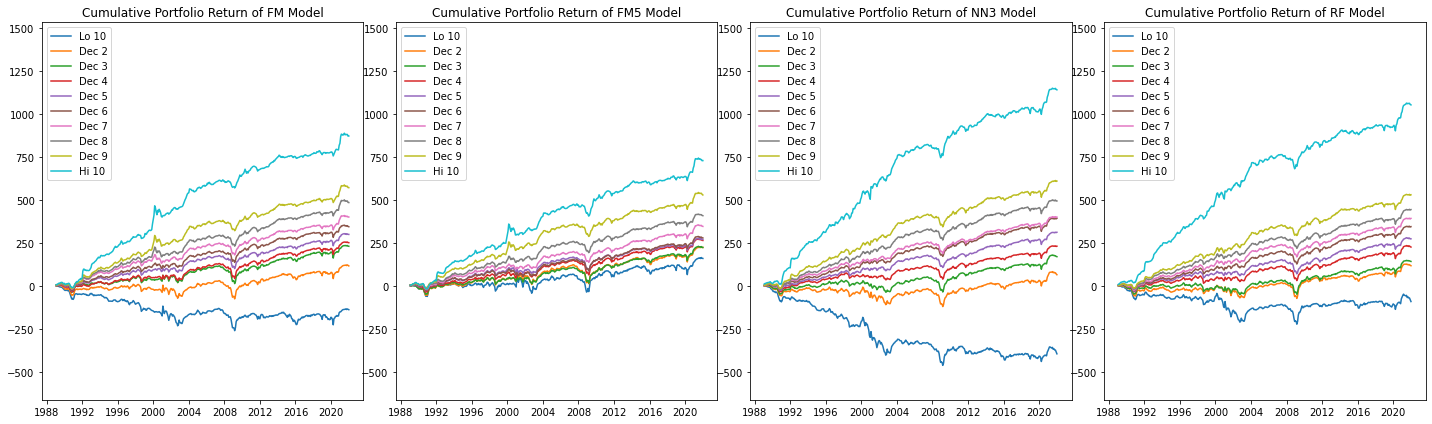

In [21]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

## Exclude Small

In [27]:
OOSresults = pd.read_csv(file_path + 'OOSresults.csv',index_col=0)
OOSresults['date'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)
OOSresults = OOSresults[OOSresults['me']>50].copy()

In [23]:
dataset.data = dataset.data[dataset.data['me']>50].copy()

In [24]:
train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
train_N = train_mask.sum()
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
validation_N = validation_mask.sum()
test_mask = (dataset.data['yyyymm'] > 198900)
test_N = test_mask.sum()
N = dataset.data.shape[0]

### R-square

#### Naive

In [29]:
OOSresults = OOSresults.assign(pred_naive = np.zeros(test_N))

#### FM

In [30]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T
# time: 40s

In [31]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm = result_oos)
# time: 24s

#### FM5

In [36]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X[['mvel1','bm','mom12m','operprof','agr']])
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T

In [37]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = X[['mvel1','bm','mom12m','operprof','agr']]
    if year < 1975:
        result_oos.extend(np.zeros(X.shape[0]))
        continue
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm5 = result_oos)

In [28]:
# Initiate a comparison dataframe
comparison = {}
# naive prediction
comparison['Naive'] = {}
comparison['Naive']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_naive'])
comparison['Naive']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_naive'])
comparison['FM'] = {}
comparison['FM']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM5'] = {}
comparison['FM5']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['FM5']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['NN3'] = {}
comparison['NN3']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['NN3']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF2'] = {}
comparison['RF2']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf2'])
comparison['RF2']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf2'])

### OOS R-squared and MSE Summarize

In [39]:
pd.DataFrame(comparison)

,Naive,FM,FM5,NN3,RF,RF2
testing MSE,252.664537,253.900075,252.910796,250.975327,251.676073,252.219528
testing R2,0.000000,-0.004890,-0.000975,0.006686,0.003912,0.001761


### OOS portfolios

In [40]:
OOSresults['fm_rank'] = OOSresults.groupby('date')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('date')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['date','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='date', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
0,0.29,0.64,0.83,0.84,1.01,1.05,1.18,1.47,2.02,4.34,4.05
1,0.29,0.24,0.23,0.21,0.21,0.22,0.24,0.26,0.33,0.62,0.58
2,1.01,2.66,3.59,4.00,4.86,4.77,5.00,5.59,6.21,7.04,6.98
3,0.31,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.15,0.40,0.55,0.59,0.72,0.75,0.81,0.95,1.16,1.71,1.70


In [41]:
OOSresults['fm5_rank'] = OOSresults.groupby('date')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('date')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['date','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='date', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
0,0.57,0.77,0.77,0.83,0.85,0.92,1.04,1.33,1.92,4.66,4.09
1,0.27,0.23,0.24,0.23,0.23,0.22,0.23,0.24,0.29,0.62,0.57
2,2.07,3.30,3.29,3.55,3.68,4.10,4.55,5.58,6.57,7.51,7.20
3,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.33,0.51,0.52,0.56,0.57,0.61,0.71,0.91,1.24,1.95,2.00


In [43]:
OOSresults['nn3_rank'] = OOSresults.groupby('date')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('date')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['date','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='date', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.55,1.02,1.03,0.97,1.01,1.29,1.29,1.46,1.76,3.30,2.75
bse,0.46,0.29,0.26,0.23,0.22,0.23,0.21,0.23,0.26,0.36,0.37
t_stats,1.21,3.45,4.04,4.29,4.65,5.67,6.11,6.45,6.76,9.14,7.39
p_value,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.21,0.52,0.68,0.75,0.83,0.98,0.99,1.06,1.18,1.75,1.97


In [44]:
OOSresults['rf_rank'] = OOSresults.groupby('date')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('date')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['date','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='date', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,1.18,1.10,1.09,1.03,1.14,1.19,1.32,1.44,1.59,2.59,1.40
bse,0.42,0.29,0.26,0.24,0.23,0.23,0.23,0.26,0.24,0.35,0.36
t_stats,2.80,3.79,4.19,4.25,4.91,5.26,5.80,5.61,6.70,7.50,3.91
p_value,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.51,0.62,0.66,0.69,0.82,0.88,0.98,1.05,1.11,1.36,0.91


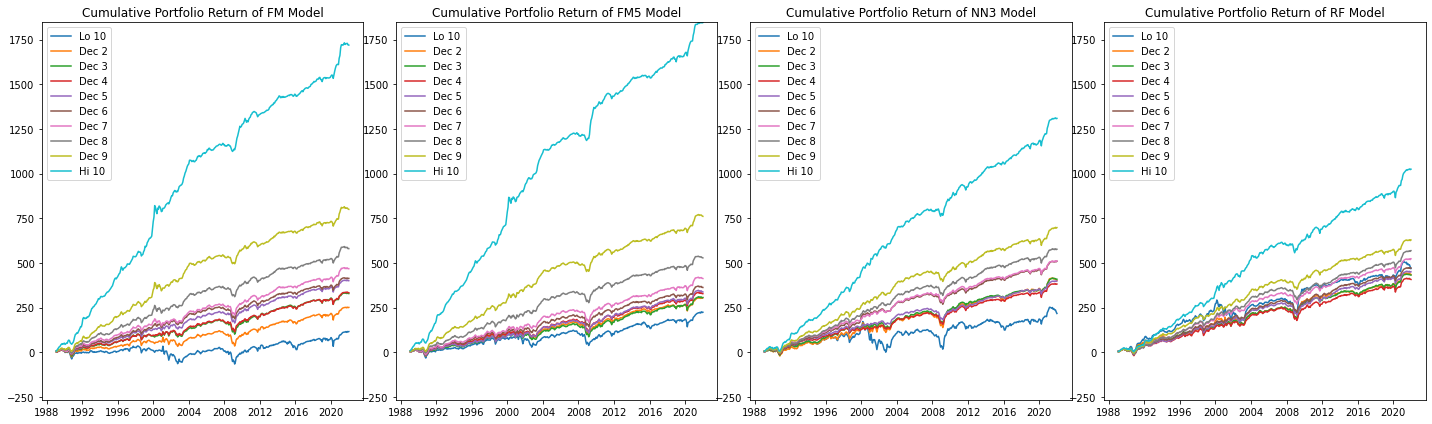

In [45]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

## lag price > 5

In [61]:
crsp = pd.read_csv(file_path + 'crsp.csv')
crsp['lag_price'] = crsp.groupby('permno')['prc'].shift(1)

# filter lag price >5 
crsp = crsp[crsp['lag_price']>5].copy()
# filter common stocks
crsp = crsp[crsp['shrcd'].isin([10,11])].copy()

In [62]:
OOSresults = pd.read_csv(file_path + 'OOSresults.csv',index_col=0)
OOSresults = OOSresults.merge(crsp[['permno','yyyymm','lag_price','shrcd','siccd']], on=['permno', 'yyyymm'], how='inner')

OOSresults['date'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)

In [63]:
# load data
dataset = DataPipeline(file_path)

In [64]:
dataset.data = dataset.data.merge(crsp[['permno','yyyymm','lag_price','shrcd','siccd']], on=['permno', 'yyyymm'], how='inner')

In [65]:
train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
train_N = train_mask.sum()
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
validation_N = validation_mask.sum()
test_mask = (dataset.data['yyyymm'] > 198900)
test_N = test_mask.sum()
N = dataset.data.shape[0]

### R-square

#### Naive

In [66]:
OOSresults = OOSresults.assign(pred_naive = np.zeros(test_N))

#### FM

In [67]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T

In [68]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm = result_oos)

#### FM5

In [69]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X[['mvel1','bm','mom12m','operprof','agr']])
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T

In [70]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = X[['mvel1','bm','mom12m','operprof','agr']]
    if year < 1975:
        result_oos.extend(np.zeros(X.shape[0]))
        continue
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm5 = result_oos)

In [71]:
# Initiate a comparison dataframe
comparison = {}
# naive prediction
comparison['Naive'] = {}
comparison['Naive']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_naive'])
comparison['Naive']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_naive'])
comparison['FM'] = {}
comparison['FM']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM5'] = {}
comparison['FM5']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['FM5']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['NN3'] = {}
comparison['NN3']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['NN3']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF2'] = {}
comparison['RF2']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf2'])
comparison['RF2']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf2'])

### OOS R-squared and MSE Summarize

In [72]:
pd.DataFrame(comparison)

,Naive,FM,FM5,NN3,RF,RF2
testing MSE,203.549822,207.124654,205.828184,202.789055,203.218938,203.617877
testing R2,0.000000,-0.017562,-0.011193,0.003737,0.001626,-0.000334


### OOS portfolios

In [73]:
OOSresults['fm_rank'] = OOSresults.groupby('date')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('date')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['date','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='date', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.22,0.31,0.60,0.67,0.83,0.87,1.06,1.14,1.35,1.64,1.85
bse,0.35,0.29,0.27,0.25,0.24,0.24,0.24,0.24,0.25,0.33,0.37
t_stats,-0.63,1.08,2.21,2.64,3.50,3.58,4.45,4.70,5.30,4.96,4.97
p_value,0.53,0.28,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.11,0.18,0.38,0.44,0.56,0.61,0.75,0.79,0.87,0.84,0.88


In [74]:
OOSresults['fm5_rank'] = OOSresults.groupby('date')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('date')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['date','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='date', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.16,0.50,0.62,0.70,0.68,0.87,0.92,1.04,1.28,1.48,1.32
bse,0.37,0.29,0.27,0.23,0.26,0.24,0.22,0.22,0.25,0.31,0.32
t_stats,0.43,1.71,2.34,3.10,2.66,3.60,4.13,4.69,5.17,4.70,4.12
p_value,0.67,0.09,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.08,0.29,0.41,0.47,0.45,0.59,0.67,0.75,0.83,0.78,0.71


In [75]:
OOSresults['nn3_rank'] = OOSresults.groupby('date')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('date')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['date','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='date', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.62,0.23,0.63,0.75,0.91,1.06,1.06,1.22,1.35,1.61,2.24
bse,0.42,0.30,0.27,NaN,NaN,0.23,0.22,0.23,0.26,0.29,0.38
t_stats,-1.50,0.76,2.34,NaN,NaN,4.64,4.82,5.36,5.16,5.55,5.93
p_value,0.14,0.45,0.02,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.26,0.13,0.42,0.56,0.69,0.78,0.79,0.89,0.91,1.02,1.60


In [76]:
OOSresults['rf_rank'] = OOSresults.groupby('date')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('date')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['date','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='date', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.02,0.47,0.62,0.73,0.85,0.89,1.03,1.08,1.18,1.37,1.35
bse,0.39,0.29,0.27,0.25,0.24,0.22,0.23,0.23,0.24,0.30,0.34
t_stats,0.04,1.62,2.34,2.90,3.60,3.98,4.40,4.76,4.92,4.53,3.98
p_value,0.97,0.11,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.01,0.26,0.39,0.50,0.61,0.67,0.77,0.81,0.85,0.82,1.03


In [77]:
OOSresults['rf2_rank'] = OOSresults.groupby('date')['pred_rf2'].transform(lambda x: x.rank(pct = True))
OOSresults['rf2_portfolio'] = OOSresults.groupby('date')['rf2_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf2_EW_portfolio = OOSresults.groupby(['date','rf2_portfolio'])['exret'].mean().reset_index()
rf2_EW_portfolio = rf2_EW_portfolio.pivot(index='date', columns='rf2_portfolio', values='exret')
rf2_EW_portfolio['HML'] = rf2_EW_portfolio['Hi 10'] - rf2_EW_portfolio['Lo 10'] 
rf2_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf2_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.01,0.40,0.61,0.73,0.90,0.96,1.00,1.07,1.19,1.38,1.37
bse,0.40,0.30,0.28,0.26,0.24,0.22,0.23,0.22,0.24,0.28,0.34
t_stats,0.02,1.34,2.21,2.84,3.73,4.25,4.42,4.98,4.94,4.85,4.07
p_value,0.98,0.18,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.00,0.22,0.38,0.49,0.63,0.70,0.74,0.82,0.86,0.84,1.03


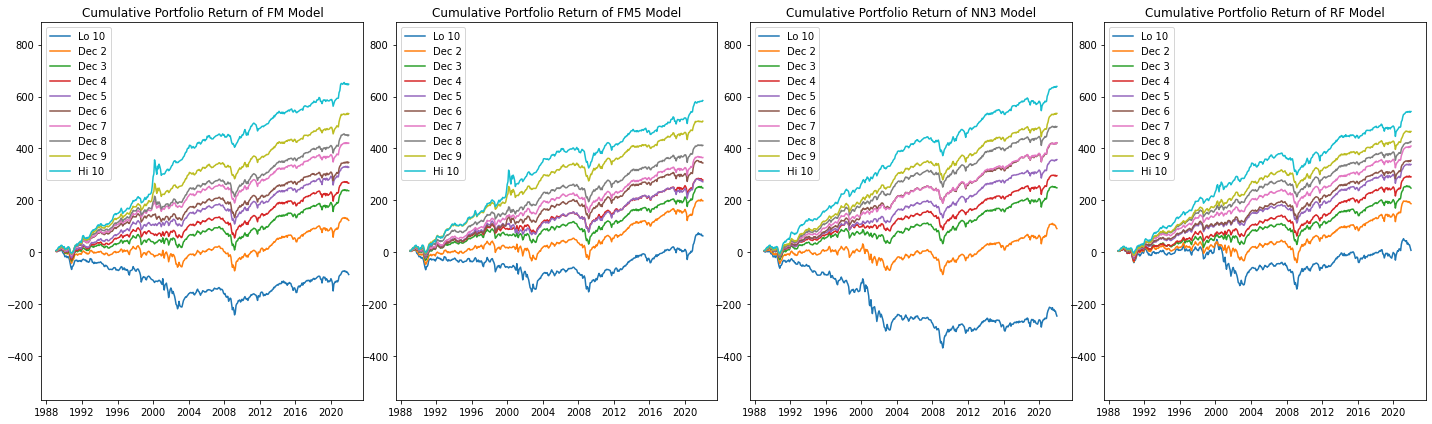

In [81]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()